# Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon

# We use the Airline data for a clear visual comparison
y = load_airline()
y_train = y[:-24] # Hold out last 2 years
y_test = y[-24:]
fh = ForecastingHorizon(y_test.index, is_relative=False)

print(f"Training Range: {y_train.index.min()} to {y_train.index.max()}")
print(f"Forecasting 24 months ahead...")

Training Range: 1949-01 to 1958-12
Forecasting 24 months ahead...


# Chronos

In [2]:
from sktime.forecasting.chronos import ChronosForecaster

print("Running Amazon Chronos...")
chronos = ChronosForecaster(
    model_path="amazon/chronos-t5-tiny", 
    config={
        "device_map": "cpu",
        "torch_dtype": "float32" # Use float32 for CPU compatibility
    }
)

chronos.fit(y_train)
y_pred_chronos = chronos.predict(fh)

Running Amazon Chronos...


# Moirai

In [4]:
# from sktime.forecasting.moirai_forecaster import MOIRAIForecaster

# # Moirai is designed to be a Universal Masked Encoder
# print("Running Salesforce Moirai...")
# moirai = MOIRAIForecaster(
#     checkpoint_path="sktime/moirai-1.0-R-small", # sktime hosts a specific small weight set
#     context_length=64,
#     patch_size=32,
#     num_samples=100     # Moirai is inherently probabilistic
# )

# moirai.fit(y_train)
# y_pred_moirai = moirai.predict(fh)

In [8]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster

print("Running IBM TinyTimeMixer...")

# We use 'fit_strategy="zero-shot"' to force the model to use 
# its pretrained weights (Context: 512, Horizon: 96) without retraining.
ttm = TinyTimeMixerForecaster(
    model_path="ibm/TTM",
    fit_strategy="zero-shot" 
)

# The model internally predicts 96 steps, but sktime will 
# automatically slice it down to match our 'fh' (24 steps).
ttm.fit(y_train, fh=fh)
y_pred_ttm = ttm.predict(fh)

Running IBM TinyTimeMixer...


# Visualization

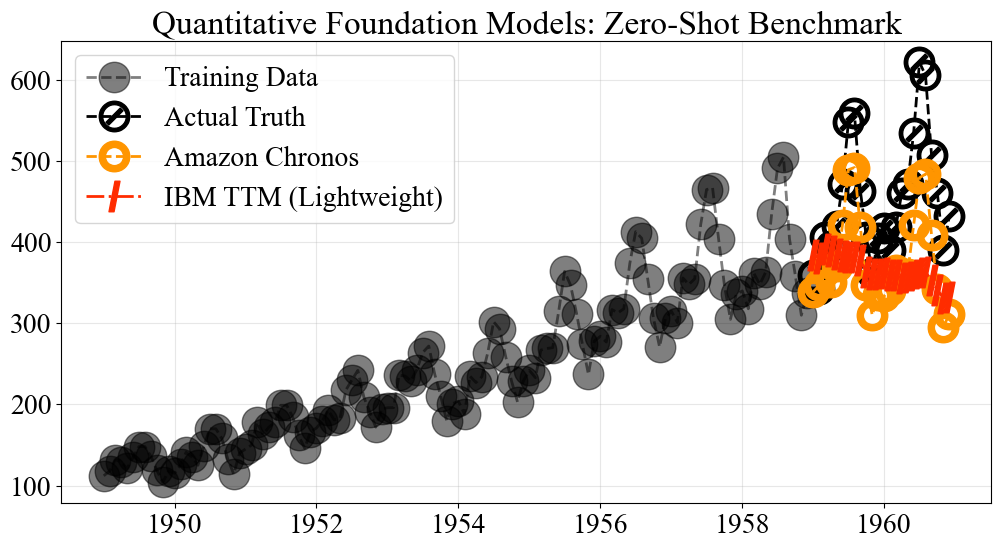

In [10]:
plt.figure(figsize=(12, 6))

# Convert PeriodIndex to Timestamp for Matplotlib
# Use .to_timestamp() on the index for x-axis
plt.plot(y_train.index.to_timestamp(), y_train, label="Training Data", color="black", alpha=0.5)
plt.plot(y_test.index.to_timestamp(), y_test, label="Actual Truth", color="black", linestyle="--")

plt.plot(
    y_pred_chronos.index.to_timestamp(), 
    y_pred_chronos, 
    label="Amazon Chronos", 
    linewidth=2
)

plt.plot(
    y_pred_ttm.index.to_timestamp(), 
    y_pred_ttm, 
    label="IBM TTM (Lightweight)", 
    linewidth=2, 
    linestyle="-."
)

plt.title("Quantitative Foundation Models: Zero-Shot Benchmark")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()